In [1]:
import torch
from torch import nn
from torch.nn import Parameter
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
import time

cuda = torch.cuda.is_available()
print(cuda)

True


In [119]:

class RNN(nn.Module):
    def __init__(self, input_size=9, hidden_size=100, output_size=9):
        super(RNN, self).__init__()
        MAX = 10000
        self.hidden_size = hidden_size
        self.LSTM = nn.LSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.activation = torch.nn.functional.sigmoid
        self.hidden_state0 = Parameter(torch.zeros(1, hidden_size)).float()
        self.cell_state0 = Parameter(torch.zeros(1, hidden_size)).float()
        self.zero_vector = Parameter(torch.zeros(MAX, 9)).float()
        
    def step(self, input_vector, hidden_state, cell_state):
        hidden_state, cell_state = self.LSTM(input_vector, (hidden_state, cell_state))
        return hidden_state, cell_state, self.fc(hidden_state)
    
    def forward(self, input_vectors):
        N = input_vectors.shape[0]
        T = input_vectors.shape[1] - 1
        
        hidden_state = self.hidden_state0.expand(N, self.hidden_size)
        cell_state = self.cell_state0.expand(N, self.hidden_size)
        
        for t in range(T + 1):
            hidden_state, cell_state, _ = self.step(input_vectors[:, t, :], hidden_state, cell_state)
        
        
        outputs = []
        for t in range(T):
            hidden_state, cell_state, output = self.step(self.zero_vector[:N,:], hidden_state, cell_state)
            outputs.append(self.activation(output.unsqueeze(2).transpose(1, 2)))
        return torch.cat(outputs, 1)

rnn = RNN(9, 100, 9)

In [3]:
# inputs 
all_vectors = []
T = 10
n = 200000

X = np.random.randint(0, 2, (n, T + 1, 9)).astype(float)
X[:, :, -1] = np.array(T*[0]+[1])
X[:, -1, :-1] = np.array(8 * [0])
input_vectors = Variable(torch.from_numpy(X)).float()

In [4]:
X.shape

(200000, 11, 9)

In [5]:
input_vectors = Variable(torch.from_numpy(X)).float()
print(input_vectors.shape)
#ut = rnn(input_vectors)

torch.Size([200000, 11, 9])


In [6]:
import math
def random_mini_batches_idx(m=n, mini_batch_size = 64):
    permutation = np.random.permutation(m)
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) 
    list_of_indices = []
    for k in range(0, num_complete_minibatches):
        list_of_indices.append(np.array(list(permutation[k * mini_batch_size: k * mini_batch_size + mini_batch_size])))
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        list_of_indices.append(np.array(list(permutation[num_complete_minibatches * mini_batch_size : m])))
    return list_of_indices

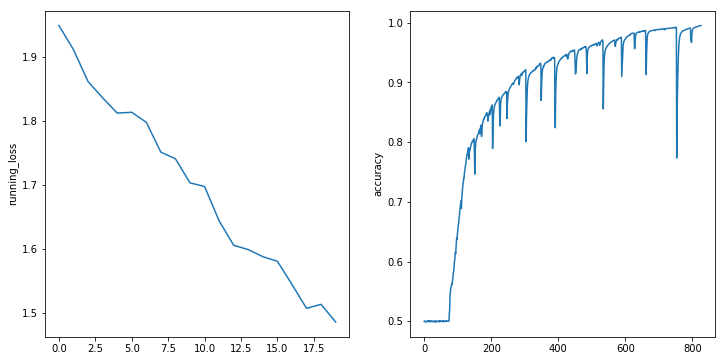

[44,    90] loss: 1.4864, approx accuracy: 0.9955, norms of weights: 302.68
Variable containing:
(0 ,.,.) = 

Columns 0 to 5 
   4.3528e-02  1.0000e+00  9.8890e-01  3.9321e-02  9.9879e-01  6.3469e-01
  1.0000e+00  9.9987e-01  8.2915e-07  9.1089e-01  1.1915e-13  3.4127e-03
  9.9943e-01  9.7106e-01  4.7533e-04  9.9793e-01  1.4366e-02  1.0601e-03
  1.2753e-06  6.6013e-09  9.9998e-01  2.0598e-03  1.5271e-03  2.4410e-04
  2.2633e-07  9.9602e-01  9.8744e-01  9.9986e-01  3.4224e-02  1.9033e-04
  1.0061e-03  9.9883e-01  5.4787e-03  2.4565e-01  9.7821e-01  9.2284e-03
  9.9884e-01  4.2458e-04  9.6684e-01  1.0000e+00  9.9998e-01  1.0530e-07
  9.9998e-01  9.9992e-01  1.3443e-02  5.1371e-03  5.5456e-07  9.9977e-01
  9.9745e-01  1.0000e+00  9.9997e-01  9.9998e-01  2.3174e-03  9.9993e-01
  9.9990e-01  9.8767e-01  1.0000e+00  9.9969e-01  9.9997e-01  1.1022e-03

Columns 6 to 7 
   1.6334e-02  1.4653e-05
  1.4032e-08  9.8603e-01
  6.0431e-07  9.9996e-01
  9.9550e-01  6.5892e-03
  1.0000e+00  8.7519e-05


KeyboardInterrupt: 

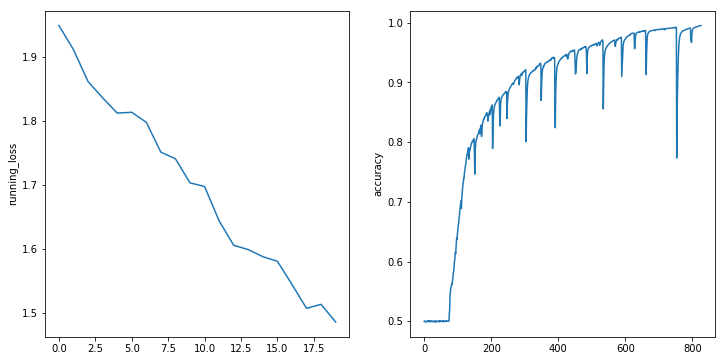

In [7]:
lr = 0.01
n_epochs = 100
criterion = torch.nn.BCELoss()
rnn = RNN()
optimizer = torch.optim.Adam(rnn.parameters(),  lr=lr)
print_every = 10
if cuda:
    print('Using CUDA')
    rnn = rnn.cuda()
    input_vectors = input_vectors.cuda()
accuracies = []
running_losses = []
lossfct = nn.functional.binary_cross_entropy
for epoch in range(n_epochs):
    minibatches_indices = random_mini_batches_idx(n, mini_batch_size=1024)
    running_loss = 0.0
    #running_bce_loss = 0.0
    for i, indices in enumerate(minibatches_indices):
        minibatch = input_vectors[indices, :, :]
    #print(list(rnn.parameters())[1])
    #print(input_vectors)
        optimizer.zero_grad()
        outputs = rnn(minibatch)
        #print(input_vectors[:-1,:].shape)
        loss = lossfct(outputs[:, :, :], minibatch[:, :-1, :], size_average=False)
        #loss = - torch.sum(minibatch[:, :-1, :] * torch.log(outputs) + (1 - minibatch[:, :-1, :]) * torch.log(1 - outputs))
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]/len(minibatch)
        #running_bce_loss += bceloss.data[0]/len(minibatch)
        if i % print_every == print_every - 1: 
            norms_of_weights = [torch.norm(x[1].data) for x in list(rnn.named_parameters()) if 'weight' in x[0]]
            accuracy_approx = torch.mean(((rnn(input_vectors[:10000,:,:])[:,:,:-1] > .5).float() == input_vectors[:10000, :-1, :-1] ).float())
            running_losses.append(running_loss/print_every)
            
            accuracies.append(accuracy_approx.data[0])
            
            plt.clf()
            plt.subplot(1,2,1)
            plt.plot(running_losses[-20:])
            plt.ylabel("running_loss")
            plt.subplot(1,2,2)
            plt.plot(accuracies)
            plt.ylabel("accuracy")
            plt.gcf().set_size_inches((12,6))
            
            display.clear_output(wait=True)
            display.display(plt.gcf())
            
            print('[%d, %5d] loss: %.4f, approx accuracy: %.4f, norms of weights: %.2f' % (epoch + 1,
                                                                                           i + 1,
                                                                                           running_loss / print_every,
                                                                                           accuracy_approx,
                                                                                           sum(norms_of_weights)))
            print(rnn(input_vectors[:1,:,:])[:,:,:-1], input_vectors[:1, :-1, :-1])
            running_loss = 0.0
            time.sleep(0.01)

In [8]:
rnn

RNN(
  (LSTM): LSTMCell(9, 100)
  (fc): Linear(in_features=100, out_features=9)
)

In [40]:
def generate_sequencess(nb_batches, max_len=20, mini_batch_size=10, cuda=False):
    # module = torch.cuda if cuda else torch
    #print(1)
    for batch_idx in range(nb_batches):
        # yield one batch
        T = np.random.randint(1, max_len + 1)
        X = np.random.randint(0, 2, (mini_batch_size, T + 1, 9)).astype(float)
        X[:, :, -1] = np.array(T*[0]+[1])
        X[:, -1, :-1] = np.array(8 * [0])


        yield Variable(torch.from_numpy(X)).float()  

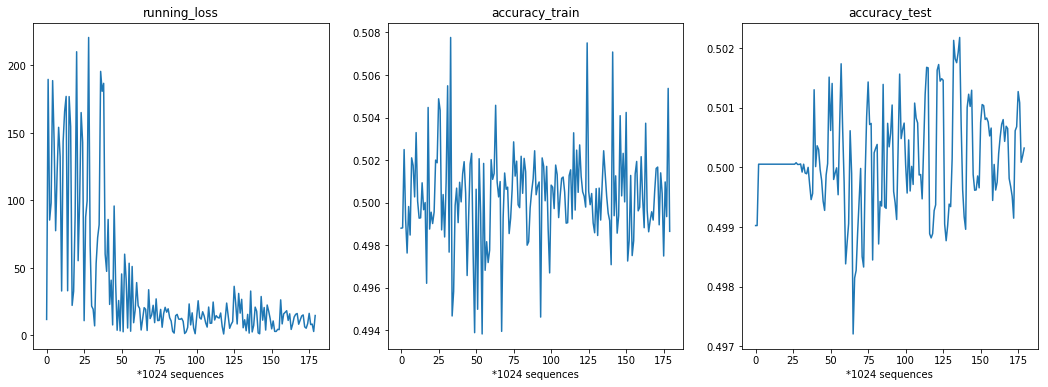

[180, 184320] loss: 14.7551, train accuracy: 0.4987, test accuracy: 0.5003, norms of weights: 1347.84


In [ ]:
cuda = True
lr = 0.5
criterion = torch.nn.BCELoss()
rnn = RNN()
optimizer = torch.optim.Adam(rnn.parameters(),  lr=lr)
print_every = 10
if cuda:
    print('Using CUDA')
    rnn = rnn.cuda()
    #input_vectors = input_vectors.cuda()
accuracies_train, accuracies_test = [], []
running_losses = []
lossfct = nn.functional.binary_cross_entropy
generator = generate_sequencess(2000, 20, 1024)
test_set = list(generate_sequencess(1, 20, 4096))[0]
if cuda:
    test_set = test_set.cuda()
step = 0
for minibatch in generator:
    if cuda:
        minibatch = minibatch.cuda()
    #print(minibatch)
    step += 1
    running_loss = 0.0
    optimizer.zero_grad()
    outputs = rnn(minibatch)
    loss = lossfct(outputs[:, :, :], minibatch[:, :-1, :], size_average=False)
    loss.backward()
    optimizer.step()
    running_loss = loss.data[0]/len(minibatch)
    norms_of_weights = [torch.norm(x[1].data) for x in list(rnn.named_parameters()) if 'weight' in x[0]]
    accuracy_train = torch.mean(((rnn(minibatch)[:,:,:-1] > .5).float() == minibatch[:, :-1, :-1] ).float())    
    accuracy_test = torch.mean(((rnn(test_set)[:,:,:-1] > .5).float() == test_set[:, :-1, :-1] ).float())
    running_losses.append(running_loss/print_every)

    accuracies_train.append(accuracy_train.data[0])
    accuracies_test.append(accuracy_test.data[0])
    
    plt.clf()
    plt.subplot(1,3,1)
    plt.plot(running_losses)
    plt.title("running_loss")
    plt.xlabel("*1024 sequences")
    plt.subplot(1,3,2)
    plt.plot(accuracies_train)
    plt.title("accuracy_train")
    plt.xlabel("*1024 sequences")
    plt.subplot(1,3,3)
    plt.plot(accuracies_test)
    plt.title("accuracy_test")
    plt.xlabel("*1024 sequences")
    plt.gcf().set_size_inches((18,6))

    display.clear_output(wait=True)
    display.display(plt.gcf())

    print('[%d, %5d] loss: %.4f, train accuracy: %.4f, test accuracy: %.4f, norms of weights: %.2f' % (step,
                                                                                                       1024 * step,
                                                                                   running_loss / print_every,
                                                                                   accuracy_train,
                                                                                   accuracy_test,
                                                                                   sum(norms_of_weights)))
    running_loss = 0.0
    time.sleep(0.01)

In [108]:
rnn.zero_vector

Variable containing:
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
[torch.FloatTensor of size 10000x9]